In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
train_loss = np.load("logs/training_loss.npy")
val_loss = np.load("logs/validation_loss.npy")
val_loss = val_loss[:-2]

In [19]:
len(train_loss), len(val_loss)

(600, 210)

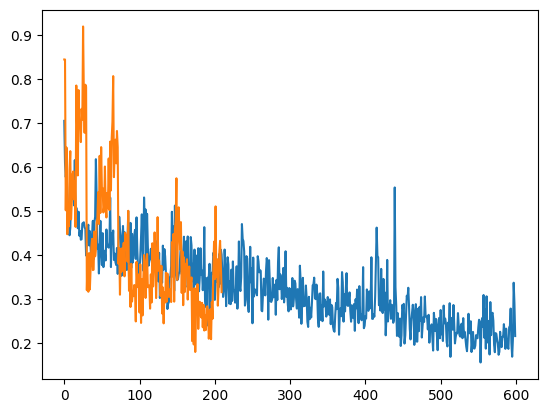

In [20]:
plt.plot(train_loss)
plt.plot(val_loss)

In [21]:
# average for 40 elements in train loss
train_averages = []
for i in range(0, len(train_loss), 40):
    chunk = train_loss[i:i+40]
    avg = sum(chunk) / len(chunk)
    train_averages.append(avg.item())

print(train_averages)


[0.48904595375061033, 0.42904168292880057, 0.4175858624279499, 0.37745448425412176, 0.35896580666303635, 0.3543914400041103, 0.33326785638928413, 0.3196809560060501, 0.28527473397552966, 0.28646073415875434, 0.3064669717103243, 0.2559561714529991, 0.23727418929338456, 0.22545130886137485, 0.2235597476363182]


In [22]:
# average for 14 elements in val loss
val_averages = []
for i in range(0, len(val_loss), 14):
    chunk = val_loss[i:i+14]
    avg = sum(chunk) / len(chunk)
    val_averages.append(avg.item())

print(val_averages)

[0.5847838861601693, 0.6955541649035045, 0.43982572640691486, 0.5270716888563973, 0.609181631888662, 0.43808507706437794, 0.34225501332964214, 0.3364648701889174, 0.3644567791904722, 0.32435656445366995, 0.4091961830854416, 0.3634922994034631, 0.2768124405826841, 0.25529247735227856, 0.364134281873703]


In [26]:
print(len(train_averages), len(val_averages))

15 15


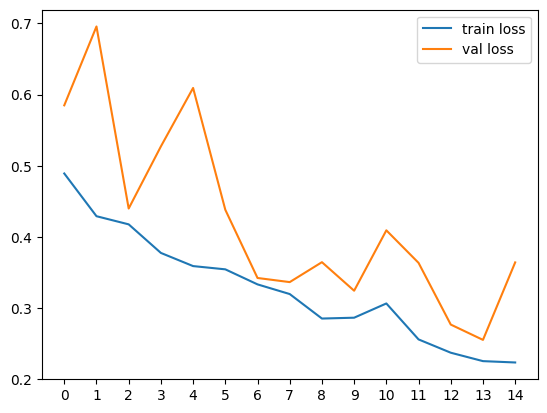

In [29]:
# plot train and val loss
plt.plot(train_averages, label="train loss")
plt.plot(val_averages, label="val loss")
plt.legend()
plt.xticks(np.arange(0, 15, 1))
plt.show()

In [30]:
from train import *

c:\Users\sathi\miniconda3\envs\dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:

test_dataset_config = ImageDatasetConfig()
test_dataset_config.mode, test_dataset_config.augment = "test", False
test_dataset = ImageDataset(image_ds_config=test_dataset_config)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [32]:
len(test_dataloader)

7

In [34]:
6 * 16

96

In [35]:
for sample in test_dataloader:
    img, mask = sample

AssertionError: Image should be RGBA